**ATTENTION**: The double well potential here is centered in 1/2 and has minimas in 0 and 1. Instead of having minimas in $\pm$ 1

c0 =  0.5004964470863342
c =  0.5004963874816895
relative_error =  1.1909105e-07


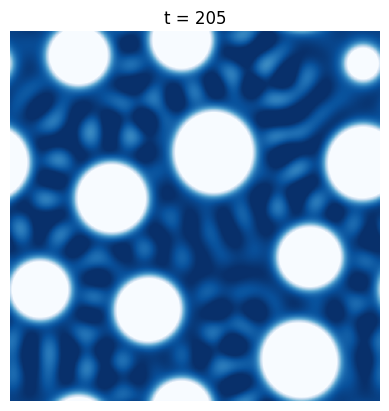

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.fft import fft2, ifft2
# import pyfftw
# import multiprocessing
# from pyfftw.interfaces.scipy_fftpack import fft2, ifft2

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2020-08-16
# Updated: 2022-03-25

# pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()
# print('Number of cpu cores:',multiprocessing.cpu_count())

"""
 The python script to solve the Cahn-Hilliard equation using
 an implicit pseudospectral algorithm
"""

Nsteps = 1000
dt = 0.1

N = 256
c_hat = np.empty((N,N), dtype=np.complex64)
dfdc_hat = np.empty((N,N), dtype=np.complex64)

c = np.empty((Nsteps,N,N), dtype=np.float32)

dx = 0.1
L = N*dx

noise = 0.1
c0 = 0.5

rng = np.random.default_rng(12345) # the seed of random numbers generator

c[0] = c0 + noise*rng.standard_normal(c[0].shape)

# plt.imshow(c)
# plt.colorbar(cmap='RdBu_r')
# # plt.title('$c_0=%.1f$'% c0)
# plt.savefig('cahn-hilliard-input.png')
# plt.show()

print('c0 = ',c[0].sum()*dx**2/L**2)

W = 1.0
M = 1.0 # mobility
kappa = 0.5 #gradient coeficient

kx = ky = np.fft.fftfreq(N, d=dx)*2*np.pi
K = np.array(np.meshgrid(kx , ky ,indexing ='ij'), dtype=np.float32)
K2 = np.sum(K*K,axis=0, dtype=np.float32)

# The anti-aliasing factor  
kmax_dealias = kx.max()*2.0/3.0 # The Nyquist mode
dealias = np.array((np.abs(K[0]) < kmax_dealias )*(np.abs(K[1]) < kmax_dealias ),dtype =bool)

"""
 The interfacial free energy density f(c) = Wc^2(1-c)^2
"""
def finterf(c_hat):
    return kappa*ifft2(K2*c_hat**2).real 

"""
 The bulk free energy density f(c) = Wc^2(1-c)^2
"""
def fbulk(c):
     return W*c**2*(1-c)*c**2

"""
 The derivative of bulk free energy density f(c) = Wc^2(1-c)^2
"""
def dfdc(c):
    #return 2*W*(c*(1-c)**2-(1-c)*c**2)
    return -4*W*(1-c**2)*c # Derivative of V(c) = W*(1-c^2)^2

c_hat[:] = fft2(c[0])
for i in range(1,Nsteps):
    dfdc_hat[:] = fft2(dfdc(c[i-1])) # the FT of the derivative
    dfdc_hat *= dealias # dealising
    c_hat[:] = (c_hat-dt*K2*M*dfdc_hat)/(1+dt*M*kappa*K2**2) # updating in time
    c[i] = ifft2(c_hat).real # inverse fourier transform
    
print('c = ',c[-1].sum()*dx**2/L**2)

print('relative_error = ',np.abs(c[-1].sum()-c[0].sum())/c[0].sum())



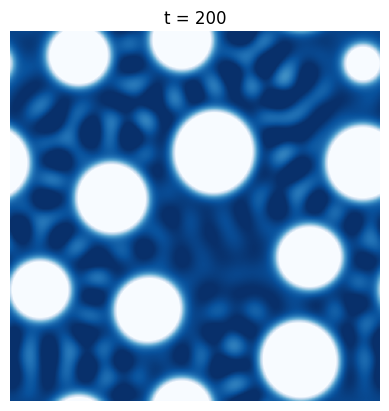

In [72]:
i = 200
plt.title("t = " + str(i))
plt.imshow(c[i],cmap='Blues', vmin=0, vmax=1.0)
plt.savefig('cahn-hilliard-c0-%.1f.png'% c0)
plt.axis("off")
plt.show()

In [62]:
c[2]

array([[0.48490897, 0.4833585 , 0.4827368 , ..., 0.48791772, 0.48767528,
        0.48658386],
       [0.4854423 , 0.48404342, 0.4835433 , ..., 0.48697433, 0.4872382 ,
        0.4866929 ],
       [0.48590782, 0.48506615, 0.48487738, ..., 0.48559007, 0.48642498,
        0.48651314],
       ...,
       [0.48223436, 0.48131984, 0.48121923, ..., 0.48852217, 0.4865806 ,
        0.48412463],
       [0.48328382, 0.48197806, 0.48161814, ..., 0.48858115, 0.4872826 ,
        0.48528215],
       [0.48421288, 0.48273534, 0.48217997, ..., 0.48843387, 0.48769066,
        0.4861323 ]], dtype=float32)

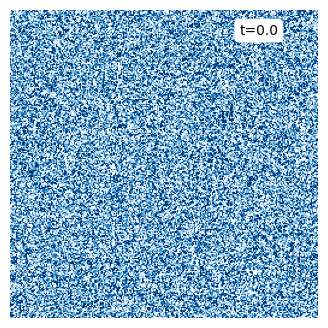

In [63]:

from matplotlib import animation
from matplotlib.animation import PillowWriter

# generate the GIF animation

fig, ax = plt.subplots(1,1,figsize=(4,4))
im = ax.imshow(c[0],cmap='Blues', vmin=-1, vmax=1.0)
#cb = fig.colorbar(im,ax=ax, label=r'$c(x,y)$', shrink=0.8)
tx = ax.text(190,20,'t={:.1f}'.format(0.0),
         bbox=dict(boxstyle="round",ec='white',fc='white'))
ax.set_title(r'$c_0=%.1f$'% c0)

ax.set_title("")
ax.axis("off")

def animate(i):
    im.set_data(c[5*i])
    im.set_clim(0.0, 1.0)
    tx.set_text('t={:.1f}'.format(5*i*dt))
    return fig,

ani = animation.FuncAnimation(fig, animate, frames= 199,
                               interval = 50)
ani.save('ch-c0='+str(c0)+'.gif',writer='pillow',fps=24,dpi=100)

$\frac{\partial c}{\partial t} = M \nabla^2\left[ \frac{\delta F}{\delta c}\right]$

$F[c] = \int \text{d}{\mathbf{r}} \left[ \frac{\kappa}{2} (\nabla c(\mathbf{r} ))^2 + f(c)\right]$

$f(c) = W c^2(1-c)^2$